In [1]:
import os
from glob import glob
from pathlib import Path

cwd = Path.cwd()
print(cwd)
prepped_data_dir = cwd / "PreppedData"

# If current path does not end in "PreppedData", move into it
if cwd.name != "PreppedData":
    if prepped_data_dir.exists():
        os.chdir(prepped_data_dir)
        print(f"Changed working directory to: {prepped_data_dir}")
    else:
        raise FileNotFoundError(f"'Annotations' directory not found at: {prepped_data_dir}")
else:
    print(f"Already in {cwd.name} directory.")

/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis
Changed working directory to: /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/PreppedData


In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import numpy as np
from collections import Counter

n_split = 5
shuffle = True
random_state = 42

data = np.load('combined_logmed_transformed.npz')
X = data['X']
y = data['y']
display(X)
print(Counter(y))
print(X.shape, y.shape)
print(np.unique(y))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    folds.append({'fold': i+1, 'train_idx': train_idx, 'val_idx': val_idx})

array([[-0.00021589, -0.00021589, -0.00021589, ..., -0.00021589,
        -0.00021589, -0.00021589],
       [-0.00021602, -0.00021602, -0.00021602, ..., -0.00021602,
        -0.00021602, -0.00021602],
       [-0.00023529, -0.00023529, -0.00023529, ..., -0.00023529,
        -0.00023529, -0.00023529],
       ...,
       [-0.00026413, -0.00026413, -0.00026413, ..., -0.00018941,
        -0.00026413, -0.00026413],
       [-0.00026318, -0.00026318, -0.00026318, ..., -0.0001802 ,
        -0.00026318, -0.00026318],
       [-0.00025636, -0.00025636, -0.00025636, ..., -0.00025636,
        -0.00025636, -0.00025636]])

Counter({np.int64(0): 1637, np.int64(1): 895, np.int64(2): 363, np.int64(4): 97, np.int64(3): 73})
(3065, 2947) (3065,)
[0 1 2 3 4]


In [3]:
for fold in folds:
    train_idx = fold['train_idx']
    val_idx = fold['val_idx']
    
    # Check if train and val indices overlap
    overlap = set(train_idx).intersection(val_idx)
    if len(overlap) > 0:
        print(f"Warning: Overlap found in fold {fold['fold']} indices: {overlap}")
    else:
        print(f"No overlap in fold {fold['fold']} indices.")

No overlap in fold 1 indices.
No overlap in fold 2 indices.
No overlap in fold 3 indices.
No overlap in fold 4 indices.
No overlap in fold 5 indices.



Fold 1
 Train label distribution: Counter({np.int64(0): 1309, np.int64(1): 716, np.int64(2): 290, np.int64(4): 78, np.int64(3): 59})
 Val label distribution:   Counter({np.int64(0): 328, np.int64(1): 179, np.int64(2): 73, np.int64(4): 19, np.int64(3): 14})
Dummy — Accuracy: 0.5351, Balanced Accuracy: 0.2000
LDA   — Accuracy: 0.4405, Balanced Accuracy: 0.4389


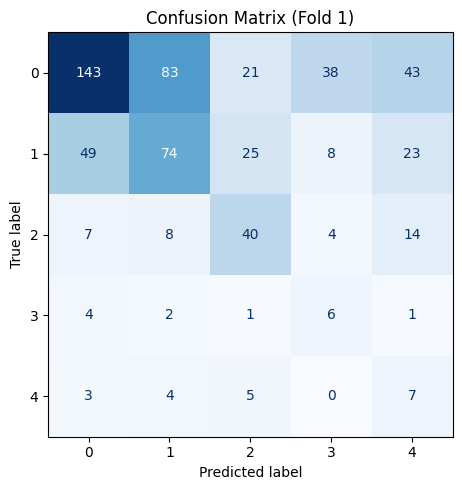


Fold 2
 Train label distribution: Counter({np.int64(0): 1309, np.int64(1): 716, np.int64(2): 290, np.int64(4): 78, np.int64(3): 59})
 Val label distribution:   Counter({np.int64(0): 328, np.int64(1): 179, np.int64(2): 73, np.int64(4): 19, np.int64(3): 14})
Dummy — Accuracy: 0.5351, Balanced Accuracy: 0.2000
LDA   — Accuracy: 0.4584, Balanced Accuracy: 0.5352


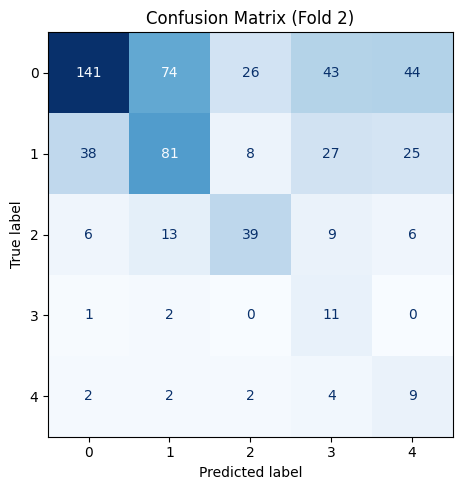


Fold 3
 Train label distribution: Counter({np.int64(0): 1310, np.int64(1): 716, np.int64(2): 290, np.int64(4): 78, np.int64(3): 58})
 Val label distribution:   Counter({np.int64(0): 327, np.int64(1): 179, np.int64(2): 73, np.int64(4): 19, np.int64(3): 15})
Dummy — Accuracy: 0.5334, Balanced Accuracy: 0.2000
LDA   — Accuracy: 0.4421, Balanced Accuracy: 0.4565


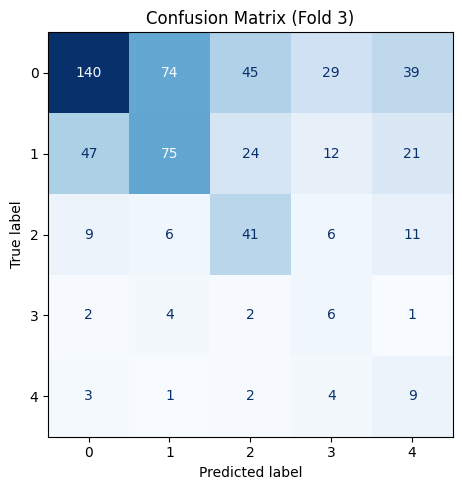


Fold 4
 Train label distribution: Counter({np.int64(0): 1310, np.int64(1): 716, np.int64(2): 291, np.int64(4): 77, np.int64(3): 58})
 Val label distribution:   Counter({np.int64(0): 327, np.int64(1): 179, np.int64(2): 72, np.int64(4): 20, np.int64(3): 15})


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# ---- Settings ----
use_shuffled_labels = False
use_pca = False          # often you skip PCA when using LDA
pca_variance = 0.95

dummy_accuracies = []
dummy_bal_accuracies = []
lda_accuracies = []
lda_bal_accuracies = []

for fold in folds:
    train_idx, val_idx = fold['train_idx'], fold['val_idx']
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    if use_shuffled_labels:
        rng = np.random.default_rng(seed=fold['fold'])
        y_train = rng.permutation(y_train)

    print(f"\nFold {fold['fold']}")
    print(" Train label distribution:", Counter(y_train))
    print(" Val label distribution:  ", Counter(y_val))

    # ---- Standardization ----
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)

    # ---- (Optional) PCA ----
    if use_pca:
        pca = PCA(n_components=pca_variance)
        X_train_p = pca.fit_transform(X_train_s)
        X_val_p   = pca.transform(X_val_s)
        print(f"PCA comps: {pca.n_components_}, var: {pca.explained_variance_ratio_.sum():.4f}")
    else:
        X_train_p, X_val_p = X_train_s, X_val_s

    # ---- Dummy Classifier ----
    dummy = DummyClassifier(strategy='most_frequent')
    dummy.fit(X_train_p, y_train)
    y_dummy     = dummy.predict(X_val_p)
    acc_dummy   = accuracy_score(y_val, y_dummy)
    bal_dummy   = balanced_accuracy_score(y_val, y_dummy)
    dummy_accuracies.append(acc_dummy)
    dummy_bal_accuracies.append(bal_dummy)

    # ---- LDA ----
    lda = LinearDiscriminantAnalysis(solver='svd')  
    # solver='svd' is default; you can also use 'lsqr' or 'eigen' with shrinkage
    lda.fit(X_train_p, y_train)
    y_lda     = lda.predict(X_val_p)
    acc_lda   = accuracy_score(y_val, y_lda)
    bal_lda   = balanced_accuracy_score(y_val, y_lda)
    lda_accuracies.append(acc_lda)
    lda_bal_accuracies.append(bal_lda)

    print(f"Dummy — Accuracy: {acc_dummy:.4f}, Balanced Accuracy: {bal_dummy:.4f}")
    print(f"LDA   — Accuracy: {acc_lda:.4f}, Balanced Accuracy: {bal_lda:.4f}")

    # ---- Confusion Matrix for LDA ----
    cm = confusion_matrix(y_val, y_lda, labels=np.unique(y))
    disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f'Confusion Matrix (Fold {fold["fold"]})')
    plt.tight_layout()
    plt.show()
    plt.close()

# ---- Summary ----
print("\n=== Summary ===")
print(f"Dummy — Mean Accuracy:         {np.mean(dummy_accuracies):.4f} "
      f"± {np.std(dummy_accuracies):.4f}")
print(f"Dummy — Mean Balanced Accuracy:{np.mean(dummy_bal_accuracies):.4f} "
      f"± {np.std(dummy_bal_accuracies):.4f}")
print(f"LDA   — Mean Accuracy:         {np.mean(lda_accuracies):.4f} "
      f"± {np.std(lda_accuracies):.4f}")
print(f"LDA   — Mean Balanced Accuracy:{np.mean(lda_bal_accuracies):.4f} "
      f"± {np.std(lda_bal_accuracies):.4f}")